In [1]:
#create a random network
import  networkx as nx

n_nodes=15  #number of nodes
min_servers=2 #minimum number of servers in the network 
ba = nx.barabasi_albert_graph(n_nodes, 2, seed=42)
#add endpoints
import random as rnd
lndv=[]
nndn=[]
for v in nx.degree(ba):
    #if node connects two neighbors
    if v[1] == 2:
        lndv.append(v[0]) 

#add endpoints to network
for i in (lndv):
    nnd=rnd.randint(1,4)
    nndn.append(nnd)   
    for j in range (nnd):        
        ba.add_node(n_nodes)
        ba.add_edge(i,n_nodes)
        n_nodes+=1
dir_ba = ba.to_directed() #convert to direct graf
del ba

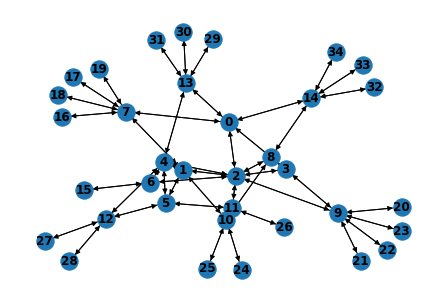

In [3]:
#draw the network without roles
import matplotlib.pyplot as plt
nx.draw(dir_ba, with_labels=True, font_weight='bold', pos=nx.spring_layout(dir_ba))
plt.savefig("network_without_roles.png")
plt.show()

In [4]:
#data for the network 
SRV_CMP_PWR = 1000

# Capacity of each link in Mb/s
SRV_LINK_CAP = 20000
ROUT_LINK_CAP = 10000
ENDP_LINK_CAP = 1000

# Probability of assigning node as router or server
SERV_PROB = 0.3
ROUT_PROB = 1 - SERV_PROB

# demand that represents data sent from servers to endpoints in MFLOPS
ENDP_DEMAND = 10
SRV_DEMAND = 0  # Server demand is adjusted later
ROUT_DEMAND = 0 #always 0 

# delay that each node introduce in ms
SRV_DELAY = 10
ROUT_DELAY = 1
ENDP_DELAY = 0.2

# cost of using each link
ENDP_WEIGHT = 10
ROUT_WEIGHT = 100
SRV_WEIGHT = 500

# cost of open each link
ENDP_LCOST = 0
ROUT_LCOST = 0
SRV_LCOST = 0

# cost of using each equipment
ENDP_COST = 0
ROUT_COST = 0
SRV_COST = 0

# colors of devices used in visualization
ENDP_COLOR = 'orange'
ROUT_COLOR = 'green'
SRV_COLOR = 'red'


In [5]:
# Assigning role for each node

while 1: #do until the network have enough servers
    color_map = []
    list_servers =[]
    for v in nx.degree(dir_ba):

        # if node connects to 2 neighbours
        if v[1] == 2:

            # mark as endpoint:
            dir_ba.nodes[v[0]]['type'] = 'Endpoint'
            dir_ba.nodes[v[0]]['demand'] = ENDP_DEMAND
            dir_ba.nodes[v[0]]['delay'] = ENDP_DELAY
            dir_ba.nodes[v[0]]['Cost'] = ENDP_COST
            color_map.append(ENDP_COLOR)

            # add maximum capacity of connection
            for connection in list(nx.neighbors(dir_ba, v[0])):
                dir_ba[v[0]][connection]['capacity'] = ENDP_LINK_CAP            
                dir_ba[v[0]][connection]['weight'] = ENDP_WEIGHT
                dir_ba[v[0]][connection]['Cost'] = ENDP_LCOST

        # if node has more connection choose whether is Server or router
        else:
            flnr=0
            for i in (lndv):            
                if i == v[0]:
                    flnr=1                 
            if flnr ==1:
                dir_ba.nodes[v[0]]['type'] = 'Router'
                dir_ba.nodes[v[0]]['demand'] = ROUT_DEMAND
                dir_ba.nodes[v[0]]['delay'] = ROUT_DELAY
                dir_ba.nodes[v[0]]['Cost'] = ROUT_COST
                color_map.append(ROUT_COLOR)
                flnr=0

            else:

                if rnd.random() <= ROUT_PROB:
                    dir_ba.nodes[v[0]]['type'] = 'Router' 
                    dir_ba.nodes[v[0]]['demand'] = ROUT_DEMAND
                    dir_ba.nodes[v[0]]['delay'] = ROUT_DELAY
                    dir_ba.nodes[v[0]]['Cost'] = ROUT_COST
                    color_map.append(ROUT_COLOR)                                                 

                else:
                    dir_ba.nodes[v[0]]['type'] = 'Server'
                    dir_ba.nodes[v[0]]['demand'] = SRV_DEMAND
                    dir_ba.nodes[v[0]]['delay'] = SRV_DELAY
                    dir_ba.nodes[v[0]]['Cost'] = SRV_COST
                    color_map.append(SRV_COLOR)
                    list_servers.append(v[0])


            adj = list(nx.neighbors(dir_ba, v[0]))
            for neighbour in adj:
                if dir_ba.nodes[v[0]]['type'] == 'Router':
                    dir_ba[v[0]][neighbour]['capacity'] = ROUT_LINK_CAP
                    dir_ba[v[0]][neighbour]['weight'] = ROUT_WEIGHT
                    dir_ba[v[0]][neighbour]['Cost'] = ROUT_LCOST
                if dir_ba.nodes[v[0]]['type'] == 'Server':
                    dir_ba[v[0]][neighbour]['capacity'] = SRV_LINK_CAP
                    dir_ba[v[0]][neighbour]['weight'] = SRV_WEIGHT
                    dir_ba[v[0]][neighbour]['Cost'] = SRV_LCOST
                    
    if len(list_servers) >= min_servers: #minimum servers at the network
        break           


In [6]:
#add demands to servers
Demand_EPs=0
Cont_serv=0
for i in dir_ba.nodes:
    if dir_ba.nodes[i]['type'] == 'Endpoint':
        Demand_EPs=dir_ba.nodes[i]['demand']+Demand_EPs

Demand_SVs=int(Demand_EPs/len(list_servers))

for i in range (len(list_servers)):
    if i == len(list_servers)-1:
        Demand_SVs=Demand_EPs-(Demand_SVs*(len(list_servers)-1))
    dir_ba.nodes[list_servers[i]]['demand']=-Demand_SVs

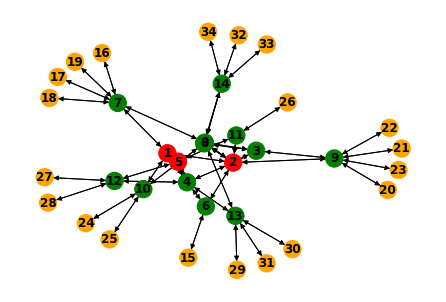

In [7]:
#draw the network with each role
nx.draw(dir_ba, pos=nx.spring_layout(dir_ba), with_labels=True, font_weight='bold', node_color=color_map)
plt.savefig("path_directed.png")
plt.show()

In [8]:
import pandas as pd

data = pd.DataFrame([], columns=['Edge_id','From_id','To_id','From_type','To_type','Capacity','U_cost', 'O_cost'])
for v in nx.degree(dir_ba): 
    adj = list(nx.neighbors(dir_ba, v[0]))
    for neig in adj:
        data = data.append(pd.DataFrame([['',v[0]+1,neig+1,dir_ba.nodes[v[0]]['type'],
                dir_ba.nodes[neig]['type'],dir_ba[v[0]][neig]['capacity'],dir_ba[v[0]][neig]['weight'],
                dir_ba[v[0]][neig]['Cost']]], columns=['Edge_id','From_id','To_id','From_type','To_type','Capacity','U_cost','O_cost']), 
                ignore_index = True)

data.index=data.index+1            
data['Edge_id'] = data.index #add index route
data.to_csv('network.csv') #create a .csv file with the information of the network
print (data)

    Edge_id From_id To_id From_type   To_type Capacity U_cost O_cost
1         1       1     3    Router    Server    10000    100      0
2         2       1     4    Router    Router    10000    100      0
3         3       1     8    Router    Router    10000    100      0
4         4       1    14    Router    Router    10000    100      0
5         5       1    15    Router    Router    10000    100      0
6         6       2     3    Server    Server    20000    500      0
7         7       2     5    Server    Router    20000    500      0
8         8       2     6    Server    Server    20000    500      0
9         9       2     8    Server    Router    20000    500      0
10       10       2    11    Server    Router    20000    500      0
11       11       3     1    Server    Router    20000    500      0
12       12       3     2    Server    Server    20000    500      0
13       13       3     4    Server    Router    20000    500      0
14       14       3     5    Serve

In [9]:
## solving network for minimum cost.
[flowCost, flowDict] = nx.algorithms.network_simplex(dir_ba,demand='demand', capacity='capacity', weight='weight')

print("total cost:", flowCost)
#print("flow dict:", flowDict)

print("Used links ((node1, node2), flow):", 
      sorted([((u, v), flowDict[u][v]) for u in flowDict for v in flowDict[u] if flowDict[u][v] > 0]))

total cost: 127400
Used links ((node1, node2), flow): [((0, 14), 30), ((1, 4), 2), ((1, 7), 44), ((1, 10), 20), ((2, 0), 26), ((2, 9), 40), ((4, 6), 10), ((4, 13), 30), ((5, 4), 38), ((5, 11), 10), ((5, 12), 20), ((6, 15), 10), ((7, 0), 4), ((7, 16), 10), ((7, 17), 10), ((7, 18), 10), ((7, 19), 10), ((9, 20), 10), ((9, 21), 10), ((9, 22), 10), ((9, 23), 10), ((10, 24), 10), ((10, 25), 10), ((11, 26), 10), ((12, 27), 10), ((12, 28), 10), ((13, 29), 10), ((13, 30), 10), ((13, 31), 10), ((14, 32), 10), ((14, 33), 10), ((14, 34), 10)]


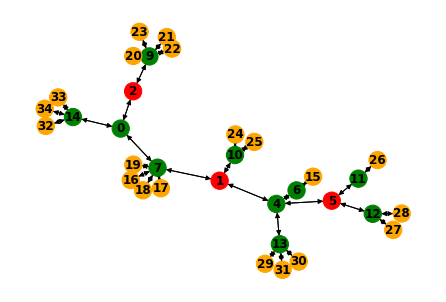

In [10]:
#Draw Graf of solution for minimum cost
spentEdges = [(u, v) for u in flowDict for v in flowDict[u] if flowDict[u][v] > 0]
color_map2=[]
Net_demand = nx.Graph()

Net_demand.add_edges_from(spentEdges)

for i in Net_demand.nodes:
    if dir_ba.nodes[i]['type'] == 'Endpoint':
        color_map2.append(ENDP_COLOR)
    if dir_ba.nodes[i]['type'] == 'Router':
        color_map2.append(ROUT_COLOR)
    if dir_ba.nodes[i]['type'] == 'Server':
        color_map2.append(SRV_COLOR)

Net_demand = Net_demand.to_directed()

nx.draw(Net_demand, pos=nx.spring_layout(Net_demand), with_labels=True, font_weight='bold',node_color=color_map2)
plt.savefig("path_directed.png")
plt.show()

In [11]:
dat_node = pd.DataFrame([], columns=['id','type'])
dat_node['id'] = data['From_id']
dat_node['type'] = data['From_type']
dat_node = dat_node.drop_duplicates(subset='id', keep='first')
dat_node = dat_node.reset_index(drop=True)
dat_node['Cost'] = ''

dat_node.index= dat_node.index+1
#add the cost of using the equipment
for i in range (1, len(dat_node)+1):
    if dat_node['type'][i][0:1] == 'R':
        dat_node['Cost'][i] = ROUT_COST
    elif dat_node['type'][i][0:1] == 'S':
        dat_node['Cost'][i] = SRV_COST
    elif dat_node['type'][i][0:1] == 'E':
        dat_node['Cost'][i] = ENDP_COST
print (dat_node)

    id      type Cost
1    1    Router    0
2    2    Server    0
3    3    Server    0
4    4    Router    0
5    5    Router    0
6    6    Server    0
7    7    Router    0
8    8    Router    0
9    9    Router    0
10  10    Router    0
11  11    Router    0
12  12    Router    0
13  13    Router    0
14  14    Router    0
15  15    Router    0
16  16  Endpoint    0
17  17  Endpoint    0
18  18  Endpoint    0
19  19  Endpoint    0
20  20  Endpoint    0
21  21  Endpoint    0
22  22  Endpoint    0
23  23  Endpoint    0
24  24  Endpoint    0
25  25  Endpoint    0
26  26  Endpoint    0
27  27  Endpoint    0
28  28  Endpoint    0
29  29  Endpoint    0
30  30  Endpoint    0
31  31  Endpoint    0
32  32  Endpoint    0
33  33  Endpoint    0
34  34  Endpoint    0
35  35  Endpoint    0


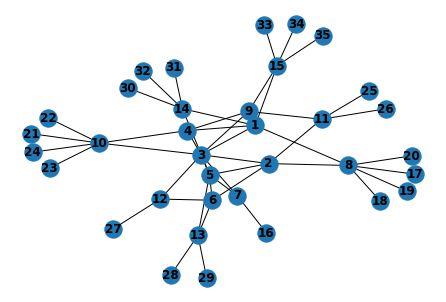

In [19]:
#create the network with the new indexes 
color_map3 = []
Network = nx.Graph()
Network.add_nodes_from([1, n_nodes])
for i in range(1, len(data)+1):
    Network.add_edge(data['From_id'][i], data['To_id'][i])

#draw the network

nx.draw(Network, with_labels=True, font_weight='bold', pos=nx.spring_layout(Network))
plt.savefig("path.png")
plt.show()
#print (data)

In [13]:
#generar demandas 
import random as rnd

list_ep=[]
#obtener los endpoints y servidores de la red 
for i in range (1, len(dat_node)+1):
    if dat_node['type'][i][0:1] == 'E':
        list_ep.append(dat_node['id'][i])

Endp_A=rnd.sample(list_ep,  3)
#print('list Endpoints',list_ep)
#print ('list Endpoints active',Endp_A)

#obtener los vecinos y el nivel en el que se encuentran (saltos)
def level_node (nram):   
    
    list_node = []
    list_type=[]
    list_level=[]
    list_temp=[]
    level=0

    list_node.append(nram)
    list_type.append(dat_node['type'][nram])
    list_level.append(level)
    fle=1      #bandera que indica que se subio de nivel
    list_temp=list_node

    while 1:
        #time.sleep(2)
        list_temp2=[]   
        if fle ==1: #aumentar el nivel de nodo
            level +=1
            fle=0
        else:
            break
        for i in range (len(list_temp)):
            adj = list(nx.neighbors(Network, list_temp[i])) #obtiene los vecinos del nodo        
            for j in range (len(adj)):
                fn=0
                for k in range (len(list_node)):
                    if adj[j]==list_node[k]:
                        fn=1
                if fn == 0:
                    list_temp2.append(adj[j])
                    list_node.append(adj[j])
                    list_type.append(dat_node['type'][adj[j]])
                    list_level.append(level)
                    fle=1
        list_temp=list_temp2

    data_level = pd.DataFrame([], columns=['id','type','level'])    
    data_level['id'], data_level['type'], data_level['level'] =list_node,list_type,list_level
    #print (data_level)
    return data_level

data_demand = pd.DataFrame([], columns=['From','To','Demand'])

for k in range (len(list_ep)):
    ctr_ser=1
    ctr_enp=1
    data_level= level_node(list_ep[k])
    for i in range (1, len(data_level['type'])):
        if data_level['type'][i][0:1]=='S' and ctr_ser<=1:#cantidad de servidores para cada demanda
            ctr_ser+=1
            data_demand = data_demand.append(pd.DataFrame([[data_level['id'][i],list_ep[k],ENDP_DEMAND]], columns=['From','To','Demand']), ignore_index = True)
            #print (data_level['type'][i],data_level['level'][i])
            break
            
data_demand.index=data_demand.index+1
print (data_demand)

   From  To Demand
1     3  16     10
2     2  17     10
3     2  18     10
4     2  19     10
5     2  20     10
6     3  21     10
7     3  22     10
8     3  23     10
9     3  24     10
10    2  25     10
11    2  26     10
12    3  27     10
13    6  28     10
14    6  29     10
15    3  30     10
16    3  31     10
17    3  32     10
18    3  33     10
19    3  34     10
20    3  35     10


In [14]:
Vn=n_nodes
En=0
for i in range(1, len(data)+1): 
    if En <= data['Edge_id'][i]:
        En = data['Edge_id'][i]

#create de file data.dat with the information of the network for optimization
with open("data.dat", "w") as f:
    f.write("""
data;
#-----------------------------------------------------------------------
#liczba łuki, zapotrzebowań oraz ścieżek

param Vn := {Vn};
param En := {En};
param Dn := {Dn};

        """.format(Vn=Vn, En=En, Dn=len(data_demand)))

#*************************************************************************

with open("data.dat", "a") as f:
    f.write("""
#-----------------------------------------------------------------------
#rozmiar zapotrzebowania d, węzeł żródłowy d, węzeł docelowy d
param : h  s  t :=
""")

    for i in range(1,len(data_demand)+1):       
        f.write("""  {d}      {h} {s} {t}
""".format(d=data_demand.index[i-1], h=data_demand['Demand'][i], s=data_demand['From'][i],t=data_demand['To'][i]))
    f.write(""";""")

#*************************************************************************     

with open("data.dat", "a") as f:
    f.write("""
#-----------------------------------------------------------------------
#węzłe-łącze  Aev(e,v) 
param : A :=
""")

    for i in range(1, En+1):       
        f.write("""  {link_number}  {From_edge_number}    1
""".format(link_number=data['Edge_id'][i], From_edge_number=data['From_id'][i]))
    f.write(""";""")

#*************************************************************************    
    
with open("data.dat", "a") as f:
    f.write("""

#----------------------------------------------------------------------- 
#węzłe-łącze  Bev(e,v) 
param : B :=
""")
        
    for i in range(1,En+1):       
        f.write("""  {link_number}  {to_edge_number}    1
""".format(link_number=data['Edge_id'][i], to_edge_number=data['To_id'][i]))
    f.write(""";""")

#*************************************************************************    
    
with open("data.dat", "a") as f:
    f.write("""

#-----------------------------------------------------------------------       
#koszt jednostkowy użycia przepływności na łączach     
param : K :=
""")
    for i in range(1,En+1):       
        f.write("""  {link_number}  {cost}
""".format(link_number=data['Edge_id'][i], cost=data['U_cost'][i]))
    f.write(""";""")
    
#*************************************************************************    
    
with open("data.dat", "a") as f:
    f.write("""

#-----------------------------------------------------------------------       
#koszt jednostkowy użycia przepływności na łączach     
param : C :=
""")
    for i in range(1,En+1):       
        f.write("""  {link_number}  {cap}
""".format(link_number=data['Edge_id'][i], cap=data['Capacity'][i]))
    f.write(""";""")
        
#*************************************************************************        
        
with open("data.dat", "a") as f:
    f.write("""
    
#----------------------------------------------------------------------- 
#upper bound for the degree of transit node v     
param : G :=
""")
    for i in range(1,Vn+1):       
        f.write("""  {node_number}  {grade}
""".format(node_number=i, grade=Network.degree[i]))        
    f.write(""";""")

#*************************************************************************      
    
    
with open("data.dat", "a") as f:
     f.write("""
end;
""")

In [15]:
#run the math-program with the data of the network created 
!cbc projekt.mod%data.dat -solve -solu result.csv

Welcome to the CBC MILP Solver 
Version: Trunk (unstable) 
Build Date: Mar 27 2019 

command line - cbc projekt.mod%data.dat -solve -solu result.csv (default strategy 1)
GMPL model file ./projekt.mod and data file ./data.dat
Reading model section from ./projekt.mod...
68 lines were read
Reading data section from ./data.dat...
462 lines were read
Generating z...
Generating c1...
Generating c2...
Generating c3...
Generating c4...
Generating c5...
Model has been successfully generated
Problem projekt has 885 rows, 1932 columns and 5796 elements
Model was imported from ./projekt.mod in 0.544541 seconds
Presolve 352 (-533) rows, 1092 (-840) columns and 3172 (-2624) elements
Perturbing problem by 0.001% of 500 - largest nonzero change 5.5082821e-05 ( 1.5830696e-05%) - largest zero change 5.5072039e-05
0  Obj 20000 Primal inf 399.99996 (40)
82  Obj 126000.02 Primal inf 309.99998 (22)
99  Obj 126000.02
Optimal - objective value 126000
After Postsolve, objective 126000, infeasibilities - dual 0

In [16]:
#clean and organize the data optained in the 
with open("result.csv", "r") as f:
    fl =f.readlines()
    f.close()

data_r = pd.DataFrame([], columns=['Demand','Edge','flow'])        
#data = data.append(pd.DataFrame([[v[0]+1,neig+1,ba.nodes[v[0]]['type'],ba.nodes[neig]['type'],ba[v[0]][neig]['cost'],ba[v[0]][neig]['capacity']]], columns=['From_index','To_index','From_type','To_type','Cost','Capacity']), ignore_index = True)        
for j in range (len(fl)):
    flag =0
    temp1=''
    temp2=''
    temp3=''
    for i in range (len(fl[j])):
        if fl[j][i] == 'x' and flag == 0:
            flag =1                    
        elif fl[j][i] == '[' and flag == 1:
            flag =2
        elif fl[j][i] != ',' and flag == 2:        
            temp1 = temp1+fl[j][i]
        elif fl[j][i] == ',' and flag == 2:
            flag =3            
        elif fl[j][i] != ']' and flag == 3:
            temp2 = temp2+fl[j][i]            
        elif fl[j][i] == ']' and flag == 3:
            flag =4
        elif fl[j][i] != ' ' and flag == 4:
            flag =5
            temp3 = temp3+fl[j][i]
        elif fl[j][i] != ' ' and flag == 5:
            temp3 = temp3+fl[j][i]
        elif fl[j][i] == ' ' and flag == 5:
            break
    if temp1 != '':        
        data_r = data_r.append(pd.DataFrame([[temp2,temp1,temp3]], columns=['Demand','Edge','flow']), ignore_index = True)        


In [17]:
Net_demand = nx.Graph()
data_r['From']=''
data_r['To']=''
for i in range(len(data_r)):
    Net_demand.add_node(data['From_id'][int(data_r['Edge'][i])])
    Net_demand.add_node(data['To_id'][int(data_r['Edge'][i])])
    data_r['From'][i]=data['From_id'][int(data_r['Edge'][i])]
    data_r['To'][i]=data['To_id'][int(data_r['Edge'][i])]

for i in range(len(data_r)):    
    Net_demand.add_edge(data_r['From'][i],data_r['To'][i])
#data_r.head()

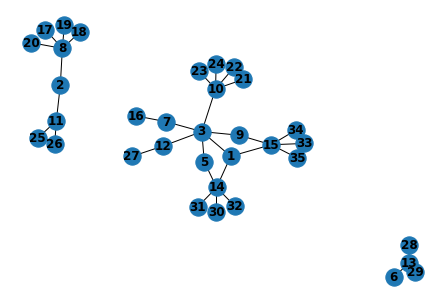

   Demand Edge flow From  To
0       1   15   10    3   7
1       1   35   10    7  16
2       2    9   10    2   8
3       2   38   10    8  17
4       3    9   10    2   8
5       3   39   10    8  18
6       4    9   10    2   8
7       4   40   10    8  19
8       5    9   10    2   8
9       5   41   10    8  20
10      6   17   10    3  10
11      6   48   10   10  21
12      7   17   10    3  10
13      7   49   10   10  22
14      8   17   10    3  10
15      8   50   10   10  23
16      9   17   10    3  10
17      9   51   10   10  24
18     10   10   10    2  11
19     10   54   10   11  25
20     11   10   10    2  11
21     11   55   10   11  26
22     12   18   10    3  12
23     12   58   10   12  27
24     13   32   10    6  13
25     13   61   10   13  28
26     14   32   10    6  13
27     14   62   10   13  29
28     15    4   10    1  14
29     15   11   10    3   1
30     15   65   10   14  30
31     16   14   10    3   5
32     16   28   10    5  14
33     16   66

In [18]:
nx.draw(Net_demand, with_labels=True, font_weight='bold', pos=nx.spring_layout(Net_demand))
plt.savefig("demands.png")
plt.show() 
print (data_r)